In [3]:
# Imports iniciales

from sklearn.metrics import mean_squared_error, zero_one_loss
from data_gen import *
from tree import ejercicio_4_tree
from copy import deepcopy
from matplotlib import pyplot as mpl
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from csv import reader
from sys import maxsize


In [4]:
# Funciones de entrenamiento

def crear_red(eta, alfa, epocas_por_entrenamiento, N2, typ="clas", gamma=0.0):
    if typ == "clas":
        red = MLPClassifier(
            hidden_layer_sizes=(N2,),
            activation="logistic",
            solver="sgd",
            alpha=0.0,
            batch_size=1,
            learning_rate="constant",
            learning_rate_init=eta,
            momentum=alfa,
            nesterovs_momentum=False,
            tol=0.0,
            warm_start=True,
            max_iter=epocas_por_entrenamiento,
        )
    else:
        red = MLPRegressor(
            hidden_layer_sizes=(N2,),
            activation="logistic",
            solver="sgd",
            alpha=gamma,
            batch_size=1,
            learning_rate="constant",
            learning_rate_init=eta,
            momentum=alfa,
            nesterovs_momentum=False,
            tol=0.0,
            warm_start=True,
            max_iter=epocas_por_entrenamiento,
        )
    return red


def entrenar_red(
    red, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test, mse=False
):
    best_error = 1

    all_error_train = []
    all_error_val = []
    all_error_test = []

    for i in range(evaluaciones):
        red.fit(X_train, np.ravel(y_train))

        results_train = red.predict(X_train)
        results_val = red.predict(X_val)
        results_test = red.predict(X_test)

        if mse:
            error_train = mean_squared_error(results_train, y_train)
            error_val = mean_squared_error(results_val, y_val)
            error_test = mean_squared_error(results_test, y_test)
        else:
            error_train = zero_one_loss(results_train, y_train)
            error_val = zero_one_loss(results_val, y_val)
            error_test = zero_one_loss(results_test, y_test)

        all_error_train.append(error_train)
        all_error_val.append(error_val)
        all_error_test.append(error_test)

        if best_error > error_val:
            best_red = deepcopy(red)

    return best_red, all_error_train, all_error_val, all_error_test

## Ejercicio 1

In [5]:
def ejercicio_1():
    capas_intermedias = [2, 10, 20, 40]
    eta = 0.1  # learning rate
    alfa = 0.9  # momemtum
    epocas_por_entrenamiento = 20
    evaluaciones = 1000

    test = generar_espirales(2000)
    case = generar_espirales(600)

    X_raw, y_raw = case.iloc[:, :-1], case.iloc[:, -1:]
    X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1:]

    # Usé 42 como seed porque lo recomendaba la documentación oficial :)
    X_train, X_val, y_train, y_val = train_test_split(
        X_raw, y_raw, test_size=0.2, random_state=42
    )

    for N2 in capas_intermedias:
        red = crear_red(eta, alfa, epocas_por_entrenamiento, N2)
        best_red, all_error_train, all_error_val, all_error_test = entrenar_red(
            red, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test
        )
        results_with_best_red = best_red.predict(X_test)
        df_results = test.copy(deep=True)
        df_results["Class"] = results_with_best_red
        plot(df_results)

/home/zeb/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


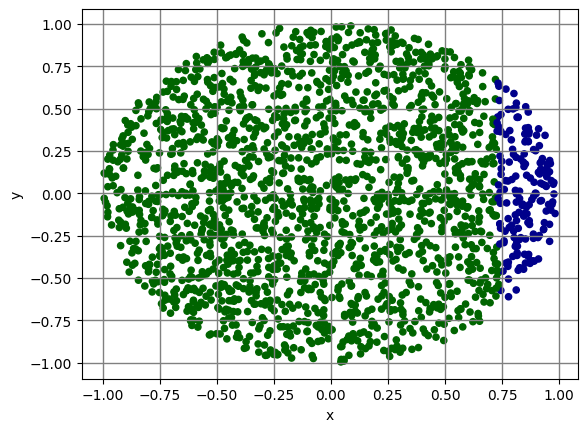

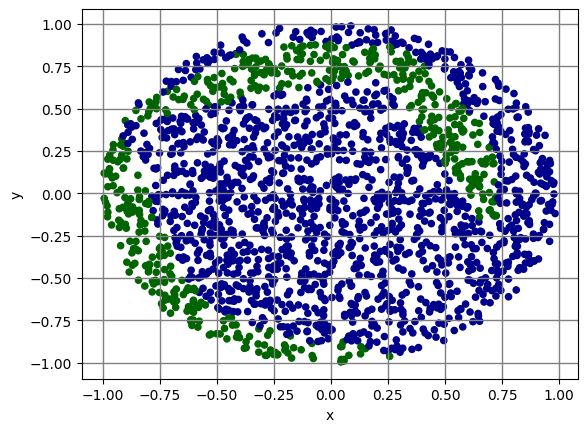

/home/zeb/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


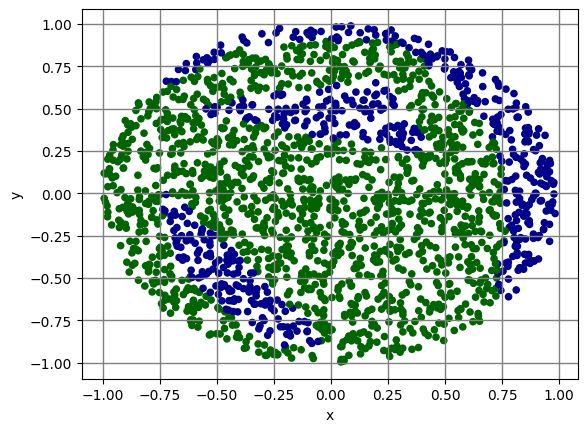

/home/zeb/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


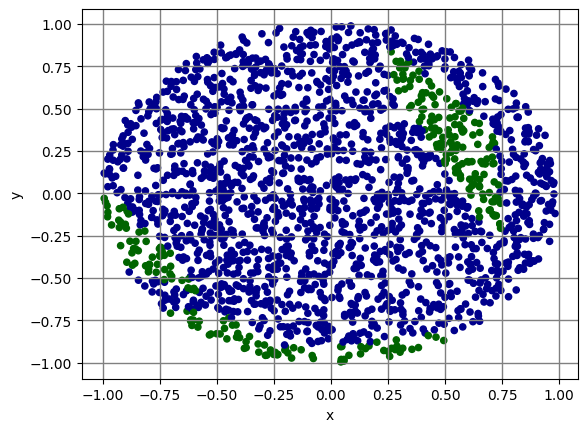

In [6]:
ejercicio_1()

### Conclusiones ejercicio 1

Como podemos observar, al incrementar la cantidad de neuronas en la red, no nos acercamos para nada a un resultado deseado. El mejor caso parecería ser con 20 neuronas, pero esto parece casi casual pues con 40 neuronas, pese a que esperaríamos que se acerque más al resultado, este se aleja. 
Por lo tanto podemos concluir que redes neuronales es una clase de soluciones que no resuelve este problema en específico

## Ejercicio 2

In [7]:
def ejercicio_2():
    momemtums = [0, 0.5, 0.9]
    learning_rates = [0.1, 0.01, 0.001]
    evaluaciones = 300
    N2 = 6
    epocas_por_entrenamiento = 50

    errors_train = []
    errors_val = []
    errors_test = []

    with open("TP_2/dos_elipses.data") as csvfile:
        lines = reader(csvfile)
        data = pd.DataFrame(lines)

    with open("TP_2/dos_elipses.test") as csvfile:
        lines = reader(csvfile)
        test = pd.DataFrame(lines)

    X_raw, y_raw = data.iloc[:, :-1], data.iloc[:, -1:]
    X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1:]

    X_train, X_val, y_train, y_val = train_test_split(
        X_raw, y_raw, test_size=0.2, random_state=42
    )

    errors_table = []

    for eta in learning_rates:
        for alfa in momemtums:
            mean_train_error = []
            mean_val_error = []
            mean_test_error = []

            best_mean_test_error = maxsize

            for i in range(10):
                red = crear_red(eta, alfa, epocas_por_entrenamiento, N2)

                best_red, error_train, error_val, error_test = entrenar_red(
                    red, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test
                )

                errors_train.append(error_train)
                errors_val.append(error_val)
                errors_test.append(error_test)

            np_error_train = np.asarray(errors_train)
            np_error_val = np.asarray(errors_val)
            np_error_test = np.asarray(errors_test)

            mean_train_error = np_error_train.mean(axis=0)
            mean_val_error = np_error_val.mean(axis=0)
            mean_test_error = np_error_test.mean(axis=0)

            min_val_error = np.min(mean_val_error)
            pos_min_val_error = np.where(mean_val_error == min_val_error)[0][0]
            min_test_error = mean_test_error[pos_min_val_error]

            if min_test_error < best_mean_test_error:
                best_mean_test_error = min_test_error
                best_eta = eta
                best_alfa = alfa
                best_train_error = mean_train_error.copy()
                best_val_error = mean_val_error.copy()
                best_test_error = mean_test_error.copy()

            errors_table.append([eta, alfa, min_test_error])

    print(
        "El mejor caso fue eta: {0}, alfa: {1} with error de test promedio: {2}".format(
            best_eta, best_alfa, best_mean_test_error
        )
    )

    errores = []
    for i in range(evaluaciones):
        errores.append(
            [best_train_error[i], i * epocas_por_entrenamiento, "Error train"]
        )
        errores.append(
            [best_val_error[i], i * epocas_por_entrenamiento, "Error validación"]
        )
        errores.append([best_test_error[i], i * epocas_por_entrenamiento, "Error test"])

    df_errors = pd.DataFrame(errores, columns=["Error", "Épocas", "Clase"])
    df_table = pd.DataFrame(errors_table, columns=["eta", "alfa", "Media error test"])
    df_errors.to_csv("TP_2/errors_training_ej_2.csv", index=False)
    df_table.to_csv("TP_2/table_ej_2.csv", index=False)

(Nota al margen, a partir de este momento comencé a guardar los resultados en archivos .csv para evitar calcular todo en runtime) 

     eta  alfa  Media error test
0  0.100   0.0          0.065600
1  0.100   0.5          0.052925
2  0.100   0.9          0.059483
3  0.010   0.0          0.101763
4  0.010   0.5          0.119770
5  0.010   0.9          0.105342
6  0.001   0.0          0.125079
7  0.001   0.5          0.139881
8  0.001   0.9          0.148889


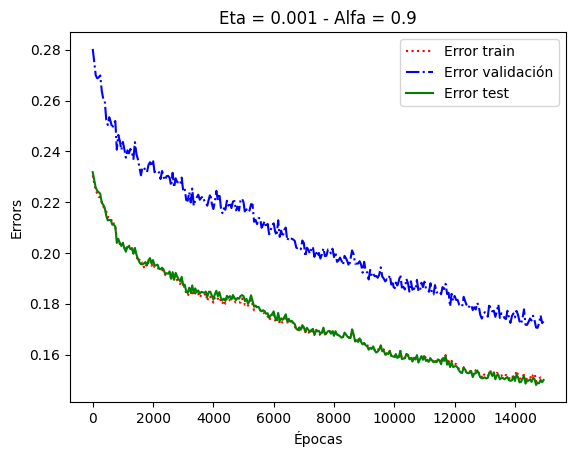

In [8]:
def ejercicio_2_print():
    df_errors_table = pd.read_csv("TP_2/table_ej_2.csv")
    print(df_errors_table)
    df_errors_training = pd.read_csv("TP_2/errors_training_ej_2.csv")
    plot_errors(df_errors_training, title="Eta = 0.001 - Alfa = 0.9")
    
ejercicio_2_print()

### Conclusiones ejercicio 2

El mejor caso fue eta: 0.001, alfa: 0.9 with error de test promedio: 0.14888888888888904

No parecería haber sobreajuste, los valores de entrenamiento  test son sorpresivamente cercanos y mejores que los de la validación (aunque decrecen de manera similar) así que parece una buena elección de parámetros para este problema.



## Ejercicio 3

In [12]:
def ejercicio_3():
    alfa = 0.9  # momemtum
    eta = 0.01  # learning_rate
    evaluaciones = 400
    N2 = 30
    epocas_por_entrenamiento = 50

    ratios = [0.95, 0.75, 0.5]

    columns = list(range(5)) + ["Class"]

    data = pd.read_csv(
        "TP_2/ikeda.data",
        names=columns,
        header=None,
        skipinitialspace=True,
        delim_whitespace=True,
    )
    test = pd.read_csv(
        "TP_2/ikeda.test",
        names=columns,
        header=None,
        skipinitialspace=True,
        delim_whitespace=True,
    )

    X_raw, y_raw = data.iloc[:, :-1], data.iloc[:, -1:]
    X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1:]

    for ratio in ratios:
        X_train, X_val, y_train, y_val = train_test_split(
            X_raw, y_raw, test_size=ratio, random_state=42
        )
        red = crear_red(eta, alfa, epocas_por_entrenamiento, N2, typ="regr")

        best_red, error_train, error_val, error_test = entrenar_red(
            red, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test, mse=True
        )

        errores = []

        for i in range(evaluaciones):
            errores.append(
                [error_train[i], i * epocas_por_entrenamiento, "Error train"]
            )
            errores.append(
                [error_val[i], i * epocas_por_entrenamiento, "Error validación"]
            )
            errores.append([error_test[i], i * epocas_por_entrenamiento, "Error test"])

        df_errors = pd.DataFrame(errores, columns=["Error", "Épocas", "Clase"])
        df_errors.to_csv("TP_2/errors_ej_3_" + str(ratio) + ".csv", index=False)

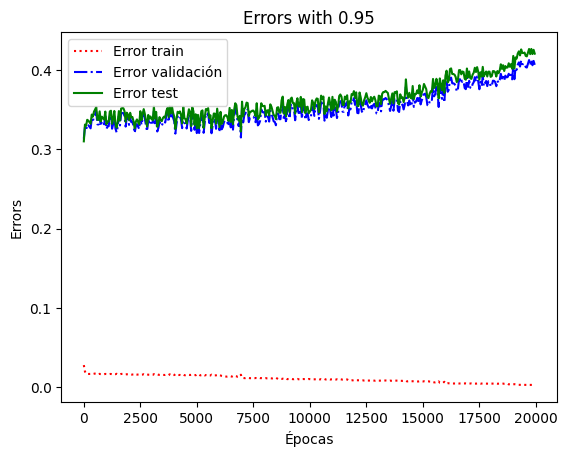

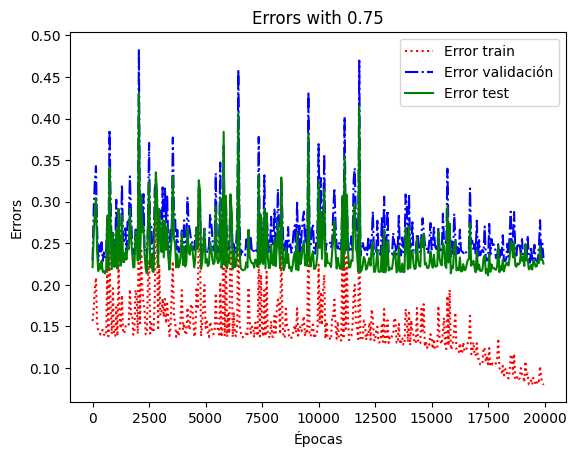

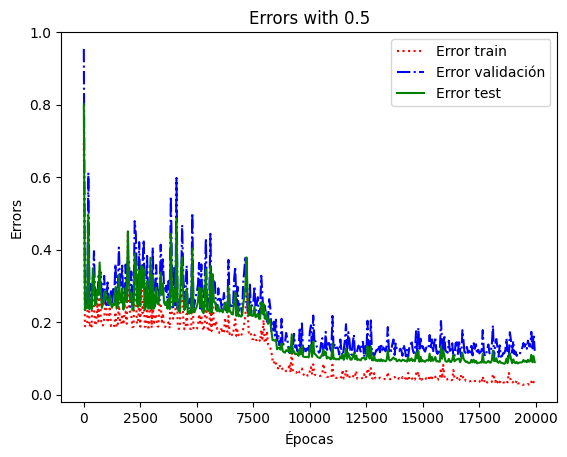

In [13]:
def ejercicio_3_print():
    df_errors_training = pd.read_csv("TP_2/errors_ej_3_0.95.csv")
    plot_errors(df_errors_training, title="Errors with 0.95")
    df_errors_training = pd.read_csv("TP_2/errors_ej_3_0.75.csv")
    plot_errors(df_errors_training, title="Errors with 0.75")
    df_errors_training = pd.read_csv("TP_2/errors_ej_3_0.5.csv")
    plot_errors(df_errors_training, title="Errors with 0.5")


ejercicio_3_print()


### Conclusiones ejercicio 3

Como se puede observar, para 0.95 el error en el entrenamiento es casi nulo, pero tiene sentido pues al poseer tan pocos datos mi red es solamente capaz de resolver el pequeño problema que le entrego. Al ser el caso más pequeño, es más probable que mis elementos sean raros, y por lo tanto, poco sirva mi red para funcionar con un gran caso de test/validación.

Para 0.75 y para 0.5, el resultado se va acercando, es decir, al tener más elementos para entrenar, estos son más representativos de los datos de validación y test. 
Es notable que la validación y el test van bastante de la mano, es decir que pese a que en 0.5 reducimos la cantidad de datos de validación, siguen siendo lo suficiemente representativos de los tests (así como los de entrenamiento lo son, pues es la misma cantidad).

0.5 parecería ser un buen balance de datos.

## Ejercicio 4

In [14]:
def entrenar_red_con_gamma(
    red, evaluaciones, X_train, y_train, X_test, y_test, mse=True
):
    best_error = 1

    all_error_train = []
    all_error_test = []
    all_wsum = []

    for i in range(evaluaciones):
        red.fit(X_train, np.ravel(y_train))

        results_train = red.predict(X_train)
        results_test = red.predict(X_test)

        if mse:
            error_train = mean_squared_error(results_train, y_train)
            error_test = mean_squared_error(results_test, y_test)
        else:
            error_train = zero_one_loss(results_train, y_train)
            error_test = zero_one_loss(results_test, y_test)
        
        wsum = sum(map(lambda weight : np.sum(np.power(weight, 2)), red.coefs_))

        
        all_error_train.append(error_train)
        all_error_test.append(error_test)
        all_wsum.append(wsum)

        if best_error > error_test:
            best_red = deepcopy(red)

    return best_red, all_error_test, all_error_train, all_wsum


def ejercicio_4():

    alfa = 0.3  # momemtum
    eta = 0.05  # learning_rate
    evaluaciones = 4000
    N2 = 6
    epocas_por_entrenamiento = 20

    gammas = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

    columns = list(range(5)) + ["Class"]

    data = pd.read_csv(
        "TP_2/ssp.data",
        names=columns,
        sep=",",
        header=None,
        skipinitialspace=True,
    )
    test = pd.read_csv(
        "TP_2/ssp.test",
        names=columns,
        sep=",",
        header=None,
        skipinitialspace=True,
    )

    X_train, y_train = data.iloc[:, :-1], data.iloc[:, -1:]
    X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1:]

    for gamma in gammas:     
        red = crear_red(eta, alfa, epocas_por_entrenamiento, N2, typ="regr", gamma=gamma)
        
        best_red, error_train, error_test, wsum = entrenar_red_con_gamma(red, evaluaciones, X_train, y_train, X_test, y_test)

        best_red.fit(X_train, np.ravel(y_train))

        #best_red.coefs_ son los pesos, creo

        errors = []
        weights = []

        for i in range(evaluaciones):
            
            errors.append(
                [error_train[i], i * epocas_por_entrenamiento, "Error train"]
            )
            errors.append(
                [error_test[i], i * epocas_por_entrenamiento, "Error test"]
            )
            weights.append(
                [wsum[i],i * epocas_por_entrenamiento]
            )

        df_errors = pd.DataFrame(errors, columns=["Error", "Épocas", "Clase"])
        df_errors.to_csv("TP_2/errors_ej_4_" + str(gamma) + ".csv", index=False)
        df_weights = pd.DataFrame(weights, columns=["Weight", "Épocas"])
        df_weights.to_csv("TP_2/weights_ej_4_" + str(gamma) + ".csv", index=False)
    

### Primeras conclusiones

El mejor resultado fue 1e-05, elegí ese y 0.1 para analizar

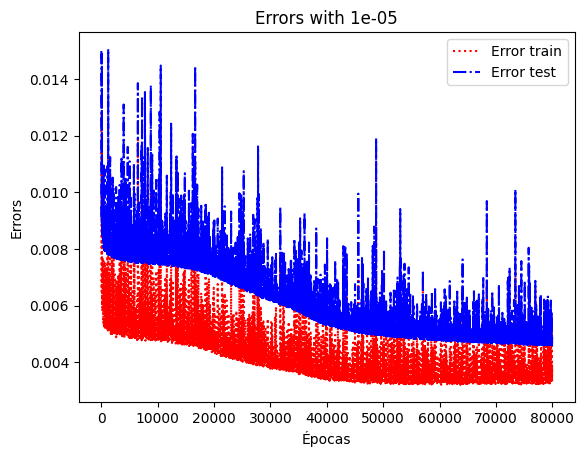

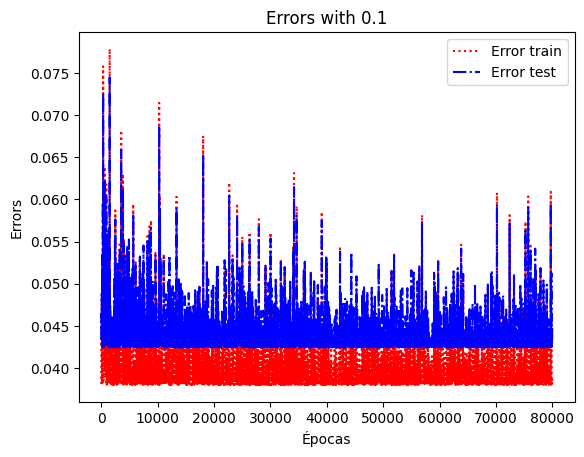

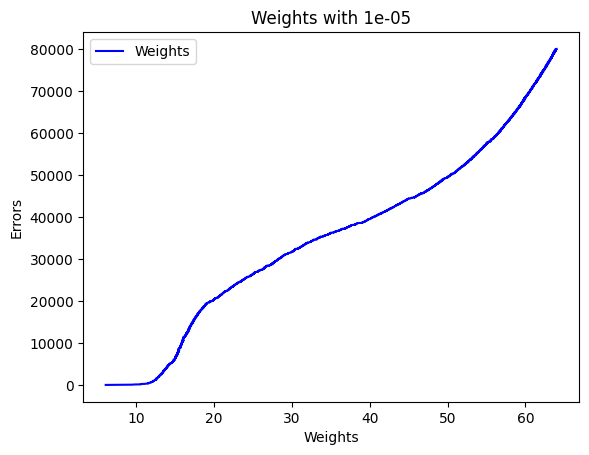

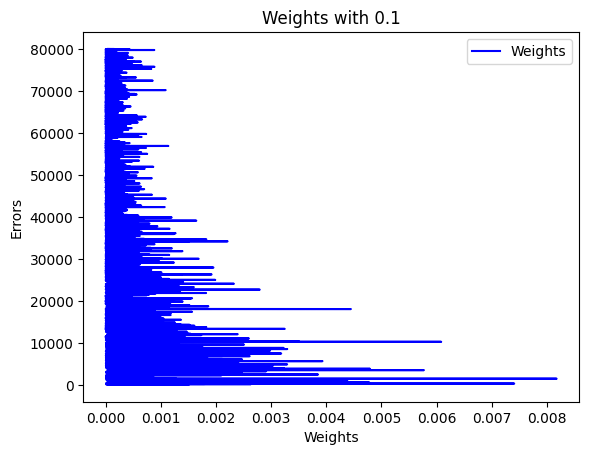

In [2]:
def ejercicio_4_print():
    df_errors_training = pd.read_csv("TP_2/errors_ej_4_1e-05.csv")
    plot_errors(df_errors_training, title="Errors with 1e-05")
    df_errors_training = pd.read_csv("TP_2/errors_ej_4_0.1.csv")
    plot_errors(df_errors_training, title="Errors with 0.1")
    df_weights_training = pd.read_csv("TP_2/weights_ej_4_1e-05.csv")
    plot_weights(df_weights_training, title="Weights with 1e-05")
    df_weights_training = pd.read_csv("TP_2/weights_ej_4_0.1.csv")
    plot_weights(df_weights_training, title="Weights with 0.1")
    
ejercicio_4_print()

### Conclusiones ejercicio 4 

Como podemos observar, para 1e-05 el resultado es bastante positivo, los errores están dentro de un margen bastante pequeño y no parecería haber un gran sobreajuste, aunque el error de entrenamiento se mantiene siempre debajo del error de test. 

Para el caso de 0.1, el resultado es bastante malo, el error en test a veces excede el 0.5 (peor que random), así que podemos concluir que con un peso de 0.1 que se mueve demasiado lejos de la solución llegando a algo bastante malo como solución.

Para los pesos, para el caso de 1e-05 es comprensible como el peso va subiendo poco a poco de forma consistente. 
En el caso de 0.1, el peso va subiendo y bajando constantemente entre pequeños valores y luego bajando. De esta forma vemos que los pesos son multiplicados por algo tan pequeño que prácticamente no afectan al resultado, apesar que el coeficiente es más grande.

## Ejercicio 5

In [15]:
def ejercicio_5():
    alfa = 0.9  # momemtum
    eta = 0.1  # learning_rate
    evaluaciones = 400
    N2 = 6
    epocas_por_entrenamiento = 20
    gamma = 10 ** -5
    c = 0.78
    n = 250

    d_values = [2, 4, 8, 16, 32]

    errors = []

    for d in d_values:
        centros_a = centros_eja(d)

        test_case_a = generar_valores(centros_a, c * sqrt(d), d, 10000)        
        X_test, y_test = test_case_a.iloc[:, :-1], test_case_a.iloc[:, -1:]

        test_error_para = 0.0
        values_error_para = 0.0
        test_error_diag = 0.0
        values_error_diag = 0.0

    
        for j in range(20):
            values = generar_valores(centros_a, c * sqrt(d), d, n)
            red = crear_red(eta, alfa, epocas_por_entrenamiento, N2, gamma=gamma)
            X_train, y_train = values.iloc[:, :-1], values.iloc[:, -1:]

            best_red, t_errors, v_errors, wsums = entrenar_red_con_gamma(red, evaluaciones, X_train, y_train, X_test, y_test, mse=False)

            results_train = best_red.predict(X_train)
            results_test = best_red.predict(X_test)

            test_error_para +=zero_one_loss(results_test, y_test)
            values_error_para += zero_one_loss(results_train, y_train) 

        test_error_para = test_error_para / 20
        values_error_para = values_error_para / 20

        
        centros_b = centros_ejb(d)
        test_case_b = generar_valores(centros_b, c, d, 10000)
        X_test, y_test = test_case_b.iloc[:, :-1], test_case_b.iloc[:, -1:]

        for j in range(20): 
            values = generar_valores(centros_b, c, d, n)
            red = crear_red(eta, alfa, epocas_por_entrenamiento, N2, gamma=gamma)
            X_train, y_train = values.iloc[:, :-1], values.iloc[:, -1:]

            best_red, test_error, values_error, wsums = entrenar_red_con_gamma(red, evaluaciones, X_train, y_train, X_test, y_test, mse=False)

            results_train = best_red.predict(X_train)
            results_test = best_red.predict(X_test)

            test_error_diag +=zero_one_loss(results_test, y_test)
            values_error_diag += zero_one_loss(results_train, y_train) 

        test_error_diag = test_error_para / 20
        values_error_diag = values_error_para / 20

        errors.append([test_error_para, d, "Test_Parallel_NN"])
        errors.append([values_error_para, d, "Val_Parallel_NN"])
        errors.append([test_error_diag, d, "Test_Diagonal_NN"])
        errors.append([values_error_diag, d, "Val_Diagonal_NN"])
    
    df_errors = pd.DataFrame(errors, columns=["Error", "D", "Type"])
    df_errors.to_csv("TP_2/errors_ej_5.csv", index=False)


def plot_error_lines_with_dimensions(error_dataframe):
    colors = ["red", "red", "blue", "blue", "green", "green", "orange", "orange"]
    line = [":", "-", ":", "-", ":", "-", ":", "-"]
 
    types = list(pd.unique(error_dataframe['Type']))

    for i in range(len(types)):
        df = error_dataframe[ error_dataframe['Type'] == types[i]]
        mpl.plot(
            df["D"],
            df["Error"],
            color=colors[i],
            label=types[i],
            linestyle=line[i],
        )

    mpl.xlabel("Sizes")
    mpl.ylabel("Error")
    mpl.legend()

    mpl.show()

def ejercicio_5_print():
    df_errors_tree = pd.read_csv("TP_1/errors_ej_4.csv")
    df_errors_nn = pd.read_csv("TP_2/errors_ej_5.csv")
    df_errors = pd.concat([df_errors_tree,df_errors_nn])
    plot_error_lines_with_dimensions(df_errors)


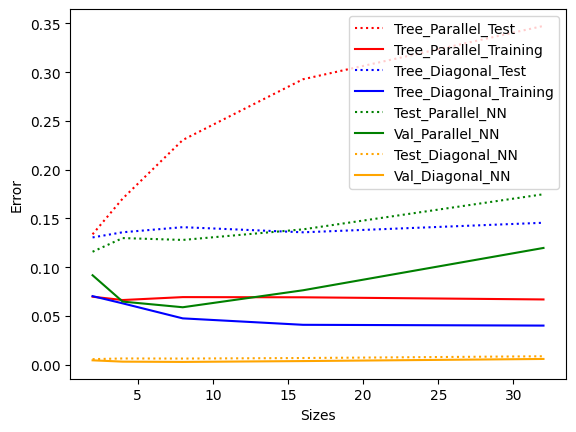

In [16]:
ejercicio_5_print()

### Conclusiones Ejercicio 5

Las redes neuronales resultan superiores en todo sentido a los árboles, para este problema. Me resulta sorpresivo que el test Diagonal de redes neuronales de tan bajo para el caso diagonal, es demasiado positivo, pero en ambos casos resulta notable lo mejor que es. 
También hay que considerar el excesivo tiempo que requiere una red neuronal para entrenarse versus la respuesta prácticamente inmediata de los árboles. Quizás para un número lo suficientemente grande, esto resulta significativo frente a la búsqueda de respuesta.